In [77]:
import numpy as np

In [78]:
images_url = "./CUB_200_2011/images.txt"
train_test_split_url = "./CUB_200_2011/train_test_split.txt"
classes_url = "./CUB_200_2011/classes.txt"
image_class_labels_url = "./CUB_200_2011/image_class_labels.txt"

Loading .txt file

In [79]:
image = np.genfromtxt(images_url , delimiter=' ', dtype=str) #<image_id> <image_name>
train_test_split = np.genfromtxt(train_test_split_url, delimiter=" ", dtype=str) #<image_id> <is_training_image>
classes = np.genfromtxt(classes_url, delimiter=" ", dtype=str) #<class_id> <class_name>
image_class_labels = np.genfromtxt(image_class_labels_url, delimiter=" ", dtype=str).astype(int) #<image_id> <class_id>

<table>
    <tr>
        <td>image</td>
        <td>&lt;image_id&gt; &lt;image_name&gt;</td>
    </tr>
    <tr>
        <td>train_test_split</td>
        <td>&lt;image_id&gt; &lt;is_training_image&gt;</td>
    </tr>
    <tr>
        <td>classes</td>
        <td>&lt;class_id&gt; &lt;class_name&gt;</td>
    </tr>
    <tr>
        <td>image_class_labels</td>
        <td>&lt;image_id&gt; &lt;class_id&gt;</td>
    </tr>
</table>

In [80]:
image = {int(row[0]): "CUB_200_2011/images/"+row[1] for row in image}
train_test_split = {int(row[0]): int(row[1]) for row in train_test_split}
classes = {int(row[0]): row[1] for row in classes}
image_class_labels = {int(row[0]): int(row[1]) for row in image_class_labels}
print(len(image),len(train_test_split),len(classes),len(image_class_labels))

11788 11788 200 11788


In [81]:
image_name = 500

print(image_name, image[image_name])
print(image_name, image_class_labels[image_name])
print(image_name, classes[image_class_labels[image_name]])
print(image_name, train_test_split[image_name])

500 CUB_200_2011/images/010.Red_winged_Blackbird/Red_Winged_Blackbird_0060_4688.jpg
500 10
500 010.Red_winged_Blackbird
500 1


In [82]:
image_train = np.array([key for key, value in train_test_split.items() if value == 1])
image_test = np.array([key for key, value in train_test_split.items() if value == 0])

image_split = {
    "train": image_train,
    "test": image_test
}

n_train = len(image_train)
n_test = len(image_test)
n_classes = len(classes)

print("Number of Images:", len(image))
print(f"n_train: {n_train}")
print(f"n_test: {n_test}")
print(f"n_classes: {n_classes}")

Number of Images: 11788
n_train: 5994
n_test: 5794
n_classes: 200


<table>
    <tr>
        <td>image_train</td>
        <td>list of &lt;image_id&gt;</td>
        <td>&lt;is_training_image&gt; == 1</td>
    </tr>
    <tr>
        <td>image_test</td>
        <td>list of &lt;image_id&gt;</td>
        <td>&lt;is_training_image&gt; == 0</td>
    </tr>
</table>

In [83]:
import matplotlib.pyplot as plt

In [84]:
def showImage(image):
    plt.imshow(plt.imread(image))
    plt.axis(False)
    plt.show()

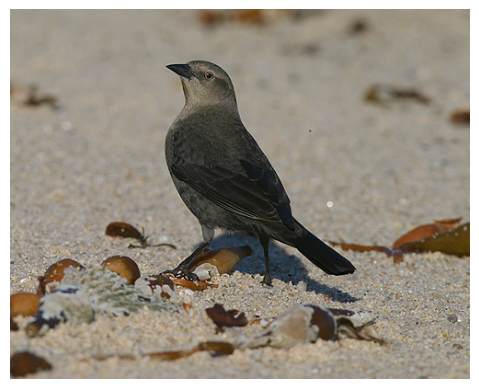

In [85]:
showImage(image[440])

## Model
### densenet

In [86]:
import torch
import torch.nn as nn
from torchvision import models

In [87]:
# hyper parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_out_ftrs = 200 # number of classes for out classification is 200
image_input_size = 244 # 244x244 image; imagas are resized to this size
batch_size = 4
# batch_size_test = 1
learning_rate = 0.1
num_epoch = 10
print(device)

cuda


In [88]:
model = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1', progress = True)

In [89]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in original model: {total_params}")

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total number of training parameters in original model: {num_params}")

Total number of parameters in original model: 7978856
Total number of training parameters in original model: 7978856


In [90]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [91]:
# freeze all layers for fine tuning (not doing this takes it very long to train)
for param in model.parameters():
    param.requires_grad = False

# number of inputs in last layer
num_ftrs = model.classifier.in_features
new_layers = [
    nn.Linear(num_ftrs, 200)
]

model.classifier = nn.Sequential(*new_layers)


# printing the last layer : classifier
print(model.classifier)

model = model.to(device)

Sequential(
  (0): Linear(in_features=1024, out_features=200, bias=True)
)


In [92]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in fine-tuned model: {total_params}")

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total number of training parameters in fine-tuned model: {num_params}")

Total number of parameters in fine-tuned model: 7158856
Total number of training parameters in fine-tuned model: 205000


### Loading dataset in torch dataloader

In [93]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from PIL import Image
import time
import os

In [94]:
class ExpandGrayscales:
    def __call__(self, sample):
        return sample.expand(3,-1,-1)

transform = transforms.Compose(
    [
        transforms.Resize((image_input_size,image_input_size)),
        transforms.ToTensor(),
        ExpandGrayscales()
    ]
)

import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms.transforms import RandomPerspective, RandomAffine

augmentation_trasform = transforms.Compose([
    transforms.Resize((image_input_size, image_input_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ColorJitter(
        brightness=0.5,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomHorizontalFlip(),
    RandomPerspective(distortion_scale=0.5, p=0.5),
    RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    ExpandGrayscales()
])

In [95]:
class CUBDataset(Dataset):
    def __init__(self, image_id, id_to_url, image_class_labels, transform):
        self.x = [id_to_url[x] for x in image_id]
        self.y = [image_class_labels[x] for x in image_id]
        self.n_samples = len(image_id)
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(self.x[index])
        img = self.transform(img)
        return img, self.y[index]-1
    
    def __len__(self):
        return self.n_samples

### Data Augmentation Process

In [96]:
augment_train_dataset = CUBDataset(
    image_id=image_split["train"],
    id_to_url=image,
    image_class_labels=image_class_labels,
    transform=augmentation_trasform
)

augment_batch_size = 20

augment_train_dataloader = DataLoader(
    dataset=augment_train_dataset,
    batch_size=augment_batch_size,
    shuffle=False
)

In [97]:
img_num = int(time.time())
folder_path = "CUB_200_2011/aug_images"

if not os.path.exists(folder_path):

    os.makedirs(folder_path)
    for _ in range(3):
        for images, labels in augment_train_dataloader:
            for i in range(images.shape[0]):
                file_path = folder_path + "/" + str(int(labels[i])+1) + "_img" + str(img_num) + ".png"
                save_image(images[i], file_path)
                image[img_num] = file_path
                image_split["train"] = np.append(image_split["train"], img_num)
                image_class_labels[img_num] = (int(labels[i])+1)
                img_num += 1

else:
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        class_id = int(file_name.split("_")[0])
        file_path = folder_path + "/" + file_name
        image[img_num] = file_path
        image_split["train"] = np.append(image_split["train"], img_num)
        image_class_labels[img_num] = (class_id)
        img_num += 1

In [98]:
np.random.seed(42)
np.random.shuffle(image_split["train"])
np.random.shuffle(image_split["test"])

In [99]:
# print(len(image), len(image_split["train"]), len(image_split["test"]), len(image_class_labels))
print(f"Train + Test: {len(image)}")
print(f"Train: {len(image_split['train'])}")
print(f"Test: {len(image_split['test'])}")
print(f"Image Class Label Length: {len(image_class_labels)}")

Train + Test: 29770
Train: 23976
Test: 5794
Image Class Label Length: 29770


### Creating Actual Train / Test Datasets

In [100]:
datasets = {
    x: CUBDataset(
        image_id=image_split[x],
        id_to_url=image, 
        image_class_labels=image_class_labels,
        transform=transform
    )
    for x in ["train", "test"]
}

In [101]:
dataloaders = {
    x: DataLoader(
        dataset=datasets[x],
        batch_size=batch_size,
        shuffle=False
    )
    for x in ["train", "test"]
}

In [102]:
dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "test"]
}
dataset_sizes

{'train': 23976, 'test': 5794}

In [103]:
dataloader_sizes = {
    x: len(dataloaders[x])
    for x in ["train", "test"]
}
dataloader_sizes

{'train': 5994, 'test': 1449}

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

In [105]:
step_lr_schedular = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=7,
    gamma=0.1
)

In [1]:
n_total_steps = dataloader_sizes["train"]

print(f"Training Started on {device}")
train_time = 0

for epoch in range(num_epoch):

    print(f"Epoch {epoch+1}/{num_epoch}" + "-" * 20)

    #each epoch has a training and a validation phase
    for phase in ["train", "test"]:
        time_start = time.time()
        model.train() if phase == "train" else model.eval()
        running_loss = 0.0
        running_corrects = 0.0

        for i, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(images)
                output_one_hot = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training loop
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # with torch.no_grad():
            #     output_one_hot = outputs.argmax(dim=1)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(output_one_hot == labels.data)

        if phase == "train":
                step_lr_schedular.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = 100 * running_corrects.double() / dataset_sizes[phase]

        
        epoch_time = time.time() - time_start
        if phase == "train":
            train_time += epoch_time

        print(f"{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.2f}", f"Time_Taken: {epoch_time}")

    print()

print(f"Training Finished in {train_time//60:.0f}m {train_time%60:.0f}s")

NameError: name 'dataloader_sizes' is not defined

In [ ]:
# PATH = "num_epoch_2_all_grad_on.pth"
# torch.save(model.state_dict(), PATH)